In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv('forecasting_data(1).csv')
df.head()


,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


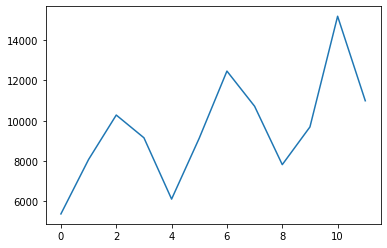

In [3]:
plt.plot(df['Sales'])
plt.show()
# This time series shows to have a pattern of ups and downs in an interval of 4 months.

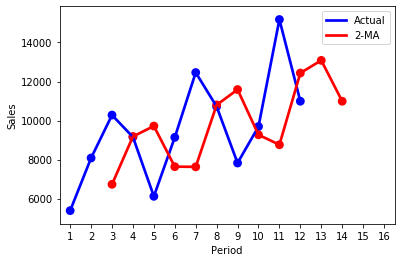

In [4]:
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period', 'Sales']) # create an empty dataframe with columns Period and Sales
    for m in range(0, to_period):
        if m < k:
            sale_predict = float('nan')
        else:
            history = df['Sales'][m-k:m] # if m=3 and k= 3, it takes the values from rows 0 to 3 (not including 3)
            sale_predict = history.mean() # takes the mean of the values included in the range of k.
        moving_average_df.loc[m] = [m+1, sale_predict] # the dataframe is populated with values for month and the 
                                                       # respective calculated sale prediction.
        
    moving_average_df['Period'] = moving_average_df['Period'].astype(int) #casting of the variables in the Period column.
    return moving_average_df #returns the dataframe with the moving average.

f, ax = plt.subplots(1,1)
ma_df = moving_average(df, 2, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')    # actual sales dataframe plotted
sns.pointplot(x='Period', y='Sales', data=ma_df, color='r') # moving average dataframe plotted
ax.legend(handles=ax.lines[::len(df)+1], labels=['Actual', '2-MA'])
plt.show()

# PLOT DOESN'T GO UNTIL THE DESIRED MONTH 16. FIX!

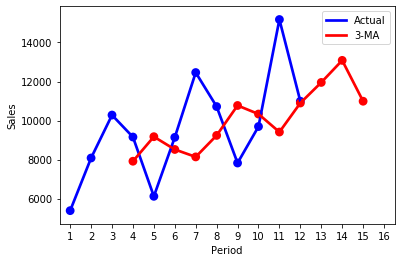

In [5]:
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period', 'Sales']) 
    #num_df = len(df)
    for m in range(0, to_period):
        if m < k: # if k=3, this if statement will be triggered until m=2
            sale_predict = float('nan')
        else:
            history = df['Sales'][m-k:m] # used to be m-k:m
            sale_predict = history.mean()
        moving_average_df.loc[m] = [m+1, sale_predict]
        
    moving_average_df['Period'] = moving_average_df['Period'].astype(int)
    return moving_average_df

f, ax = plt.subplots(1,1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='r')
ax.legend(handles=ax.lines[::len(df)+1], labels=['Actual', '3-MA'])
plt.show()

# 3. Predict future demand in month 13,14,15,16 with seasonality

In [6]:
# new_df = df.copy()

# def get_season(row):
#     if row['Period'] < 5:
#         return 'I'
#     elif row['Period'] > 8:
#         return 'III'
#     else:
#         return 'II'


# new_df['Cycle'] = new_df.apply(get_season, axis=1)
# new_df

In [7]:

# C1_mean = new_df[new_df['Cycle'] == 'I']['Sales'].mean()
# C2_mean = new_df[new_df['Cycle'] == 'II']['Sales'].mean()
# C3_mean = new_df[new_df['Cycle'] == 'III']['Sales'].mean()

# def get_seq(row):
#     return row['Period']%4 or 4

# new_df['Seq'] = new_df.apply(get_seq, axis=1)
# new_df

In [8]:
# 1) Compute the average sales for each cycle

new_df = df.copy()
average = []
step=0

for i in range(0,3):
    avg = df['Sales'][0+step:4+step].mean()
    step += 4
    for j in range (0,4):
        average.append(avg)
new_df['Average'] = average
new_df

,Period,Sales,Average
0,1,5384,8225.75
1,2,8081,8225.75
2,3,10282,8225.75
3,4,9156,8225.75
4,5,6118,9608.50
5,6,9139,9608.50
6,7,12460,9608.50
7,8,10717,9608.50
8,9,7825,10921.25
9,10,9693,10921.25


In [9]:
# 2) Compute the seasonal indices for each month of each cycle
seasonal_index = []

for i in range(0,12):
    result = new_df['Sales'].loc[i] / new_df['Average'].loc[i]
    seasonal_index.append(result)
        
new_df['Seasonal index'] = seasonal_index
new_df


,Period,Sales,Average,Seasonal index
0,1,5384,8225.75,0.654530
1,2,8081,8225.75,0.982403
2,3,10282,8225.75,1.249977
3,4,9156,8225.75,1.113090
4,5,6118,9608.50,0.636728
5,6,9139,9608.50,0.951137
6,7,12460,9608.50,1.296768
7,8,10717,9608.50,1.115367
8,9,7825,10921.25,0.716493
9,10,9693,10921.25,0.887536


In [10]:
# 3) Compute the seasonal indexes for the next cycle

# in order to do that, I found the average of all indexes of months that match each other,
# so, for instance, the average index of months 1, 5 and 9 would generate the average index
# for month 13 of the new cycle.

seasonal_index_new_cycle = []

for i in range(0,4):
    avg_seasonal_index = (new_df['Seasonal index'].loc[0+i] + 
                         new_df['Seasonal index'].loc[4+i] + 
                         new_df['Seasonal index'].loc[8+i])/3
    seasonal_index_new_cycle.append(avg_seasonal_index)

seasonal_index_new_cycle


[0.6692503182230763,
 0.9403585339798332,
 1.3121405940510693,
 1.0782505537460212]

In [11]:
# 4) Use linear regression on the average sales of cycles to predict the average sale for next cycle

from sklearn import datasets, linear_model

# Prepare the training set. Here the training set will be just the number of the cycles, which will show an ascending
# order from 1 to 3.
X_train = np.array([1,2,3]).reshape(-1,1)

# Prepare the target set
y_train = new_df["Average"].unique().reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model
regr.fit(X_train, y_train)

# Make sales predictions using the seasonal indexes generated for the new cycle
new_cycle = np.array([4]).reshape(-1,1)
avg_sales_pred = regr.predict(new_cycle)
print(f"The predicted average sales for the new cycle is {avg_sales_pred}")



The predicted average sales for the new cycle is [[12280.66666667]]


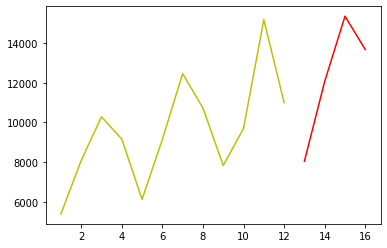

In [12]:
# 5) Compute the seasonalize forecasts

new_cycle_df = pd.DataFrame(columns=['Period', 'Sales']) 
new_cycle_df['Period'] = range(13,17)
sales_pred_list = []
for i in range(0,4):
    sales_pred = avg_sales_pred * new_df['Seasonal index'][i]
    sales_pred_list.append(sales_pred)

new_cycle_df['Sales'] = sales_pred_list

# Plot outputs
f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(new_cycle_df['Period'], new_cycle_df['Sales'], c='r')
plt.show()
